In [1]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import math

In [2]:
reviews_tokenized = pd.read_csv('reviews_tokenized.csv',encoding='utf-8-sig')

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
reviews_tokenized['text'] = reviews_tokenized['text'].apply(lambda x: x.split())

In [5]:
#vocab
def get_vocab(tokenized_data):
    word_to_idx = {}
    idx_to_word = {}
    index = 1
    for sent in tokenized_data:
        for word in sent:
            if word not in word_to_idx:
                word_to_idx[word] = index
                idx_to_word[index] = word
                index += 1
    word_to_idx['<pad>'] = 0
    idx_to_word[0] = '<pad>'
    return word_to_idx, idx_to_word

In [6]:
word_to_idx, idx_to_word = get_vocab(reviews_tokenized['text'])

In [7]:
print(word_to_idx)
print(idx_to_word)
print(len(word_to_idx))

{'테이크아웃': 1, '셔틀': 2, '인지도': 3, '보너스': 4, '많이': 5, '나오다': 6, '기준': 7, '적당하다': 8, '인성': 9, '동료': 10, '기업': 11, '대비': 12, '뚜렷하다': 13, '장점': 14, '밥맛': 15, '괜찮다': 16, '시세': 17, '주다': 18, '성과': 19, '금도': 20, '나름': 21, '편이': 22, '보고': 23, '좋다': 24, '복지': 25, '중간': 26, '정도': 27, '경쟁': 28, '따르다': 29, '외적인': 30, '식이': 31, '특히': 32, '노년': 33, 'PS': 34, '반도체': 35, '아무리': 36, '멀다': 37, '온양': 38, '지하철': 39, '닿다': 40, '서울': 41, '통근': 42, '가능': 43, '외적': 44, '뉴스': 45, '공정하다': 46, '시늉': 47, '수원': 48, '이라는': 49, '위치': 50, '제조업': 51, '국내': 52, '상위': 53, '연봉': 54, '가짐': 55, '아침': 56, '점심': 57, '저녁': 58, '이고': 59, '잡다하다': 60, '막상': 61, '사용': 62, '후광': 63, '효과': 64, '가다': 65, '삼성': 66, '다니다': 67, '인정받다': 68, '어학': 69, '비자': 70, '계발': 71, '휴가': 72, '자율': 73, '출퇴근': 74, '제쿠킹': 75, '클래스': 76, '매년': 77, '열리다': 78, '축제': 79, '체육대회': 80, '반바지': 81, '보이다': 82, '사내': 83, '문화': 84, '여성': 85, '출산휴가': 86, '장려': 87, '눈치': 88, '려고': 89, '않다': 90, '직급': 91, '맛있다': 92, '이유': 93, '임밸류': 94, '가장': 95, '크다': 96, '글로벌': 97, 

In [13]:
def get_index(tokenized_data, word_to_idx):
    all_result = []
    for sent in tokenized_data:
        result = []
        for word in sent:
            result.append(word_to_idx[word])
        all_result.append(result)
    return all_result
all_result = get_index(reviews_tokenized['text'], word_to_idx)

max_length: 213
length_mean: 13.348933333333333
96% of sequences: 30.0


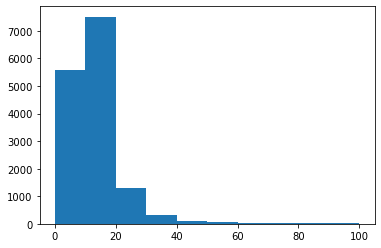

In [16]:
seq = [len(x) for x in all_result]
max_length = max(seq)
print('max_length:',max_length)
print('length_mean:',np.array(seq).mean())

import matplotlib.pyplot as plt
plt.hist(seq, bins=10, range=(0, 100));
# 불필요한 패딩을 줄이기 위해 max_length를 30으로 설정
print('96% of sequences:',np.percentile(seq,96))

In [17]:
max_length = 30
def padding(all_result, max_length=30):
    for i in range(len(all_result)):
        all_result[i] = all_result[i][-max_length:]
        all_result[i] = [0] * (max_length - len(all_result[i])) + all_result[i]
        # length 검사 #
        assert len(all_result[i]) == max_length
    return all_result

In [18]:
all_result = padding(all_result, max_length)

In [19]:
print(all_result[:1])

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]


In [20]:
#train_test_split
from sklearn.model_selection import train_test_split
train_data, test_data, train_label, test_label = train_test_split(all_result, reviews_tokenized['label'], test_size=0.2, random_state=42)

In [21]:
train_data  = torch.LongTensor(train_data)
test_data  = torch.LongTensor(test_data)
train_label = torch.tensor(train_label.values, dtype=torch.float32)
test_label = torch.tensor(test_label.values, dtype=torch.float32)
print('train_data_shape:',train_data.shape, 'train_label_shape:',train_label.shape, 'test_data_shape:',test_data.shape, 'test_label_shape:',test_label.shape)

train_data_shape: torch.Size([12000, 30]) train_label_shape: torch.Size([12000]) test_data_shape: torch.Size([3000, 30]) test_label_shape: torch.Size([3000])


In [22]:
train_dataset = torch.utils.data.TensorDataset(train_data, train_label)
test_dataset = torch.utils.data.TensorDataset(test_data, test_label)

In [23]:
# set arguments #
batch_size = 256
vocab_size = len(word_to_idx)
embedding_size = 128
hidden_size = 64
num_layers = 3
num_classes = 1
learning_rate = 0.001
num_epochs = 10

In [24]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

In [25]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.layernorm = nn.LayerNorm(embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(0.2)
        
    
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        x = self.embedding(x)
        x = self.layernorm(x)
        x, _ = self.lstm(x, (h0, c0)) # LSTM 모듈에 input과 초기 (hidden, cell)값을 전달 
        x = self.dropout(x[:, -1, :]) # 마지막 time-step의 hidden state를 가져옴
        x = self.fc(x)
        x = torch.sigmoid(x) #BCELoss를 위해 sigmoid로 0~1사이의 확률값 출력
        return x
        

In [41]:
model = LSTM(vocab_size, embedding_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.BCELoss() # 이진 분류를 위한 loss 계산을 위해 Binary Cross Entropy 사용
optimizer = optim.Adam(model.parameters(), lr=learning_rate) #Adam optimizer 사용

In [42]:
for epoch in range(num_epochs):
    # print('epoch:',epoch+1) 
    for idx, (batch,label) in enumerate(train_loader):
        batch = batch.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(batch)
        output = output.squeeze()
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
    print('epochs:',epoch+1,'loss:',loss.item())
            

epochs: 1 loss: 0.5105299353599548
epochs: 2 loss: 0.36248937249183655
epochs: 3 loss: 0.28473779559135437
epochs: 4 loss: 0.22759012877941132
epochs: 5 loss: 0.16954071819782257
epochs: 6 loss: 0.12096809595823288
epochs: 7 loss: 0.10601133853197098
epochs: 8 loss: 0.07263118028640747
epochs: 9 loss: 0.04228103160858154
epochs: 10 loss: 0.040270812809467316


In [43]:
# test
from sklearn.metrics import roc_auc_score
predict_result = []
with torch.no_grad():
    correct = 0
    total = 0
    for (batch, label) in test_loader:
        batch = batch.to(device)
        label = label.to(device)
        output = model(batch)
        output = output.squeeze()
        predict_result.extend(output) #probabilty
        predicted = torch.round(output) #binary
        total += label.size(0)
        correct += (predicted == label).sum().item()
    
    
    print('Roc-auc-score of the model on the test data: {}%'.format(round(100*roc_auc_score(test_label, predict_result),2)))
    print('Accuracy of the model on the test data: {} %'.format(round(100 * correct / total,2)))

Roc-auc-score of the model on the test data: 94.19%
Accuracy of the model on the test data: 86.67 %


In [44]:
# inference #
from konlpy.tag import Okt
okt = Okt()
def inference(model, sentence):
    model.eval()
    tokenized = [okt.morphs(sentence, stem=True)]
    indexed = get_index(tokenized, word_to_idx)
    padded = padding(indexed, max_length)
    padded = torch.LongTensor(padded).to(device)
    output = model(padded)
    output = output.squeeze()
    predict = torch.round(output)
    if predict == 1:
        print(sentence,':긍정')
    else:
        print(sentence,':부정')

In [45]:
inference(model, '밥맛괜찮고좋아요')
inference(model, '밥맛별로에요')
inference(model, '나쁘지않아요')
inference(model, '그냥그래요나쁘지않아요')
inference(model, '나쁘지않아요그냥그래요밥맛별로에요')
inference(model, '나쁘지않아요밥맛별로에요그냥그래요')
inference(model, '밥맛별로에요나쁘지않아요그냥그래요')

밥맛괜찮고좋아요 :긍정
밥맛별로에요 :부정
나쁘지않아요 :긍정
그냥그래요나쁘지않아요 :긍정
나쁘지않아요그냥그래요밥맛별로에요 :부정
나쁘지않아요밥맛별로에요그냥그래요 :긍정
밥맛별로에요나쁘지않아요그냥그래요 :긍정
